In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import h5py

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

COLOR = 'grey'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"supenghong","key":"849bf233560accb914b9f28744d26ef1"}'}

In [2]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!kaggle competitions download -c aerial-cactus-identification

  0% 0.00/667k [00:00<?, ?B/s]
100% 667k/667k [00:00<00:00, 43.2MB/s]
  0% 0.00/160k [00:00<?, ?B/s]
100% 160k/160k [00:00<00:00, 111MB/s]
100% 4.20M/4.20M [00:00<00:00, 34.2MB/s]

 47% 9.00M/19.2M [00:01<00:01, 5.66MB/s]
100% 19.2M/19.2M [00:01<00:00, 10.2MB/s]


In [0]:
!mkdir unknown # test images in subfolder test for prediction flow_from_directory

In [0]:
!unzip -q train.zip
!unzip -q test.zip -d unknown

In [0]:
train_dir = 'train/'
test_dir = 'unknown/test/'

# Examining data

In [6]:
Y_train = pd.read_csv('train.csv')

Y_train.shape

(17500, 2)

In [7]:
Y_train.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


0004be2cfeaba1c0361d39e2b000257b.jpg


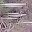

In [8]:
# Displaying an image

from IPython.display import Image
import os

print(Y_train.iloc[0, 0])

Image(os.path.join(train_dir, Y_train.iloc[0, 0]), width = 250, height = 250)

# Preprocessing data

In [0]:
train_batch_size = 250
val_batch_size = 50
random_seed = 42

train_size = 15000
val_size = 2500

In [10]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                  horizontal_flip = True,
                                  vertical_flip = True)

Using TensorFlow backend.


# flow_from_dataframe Method
 This method is useful when the images are clustered in only one folder. To put in other words images from different class/labels reside in only one folder. Generally, with such kind of data, some text files containing information on class and other parameters are provided. In this case, we will create a dataframe using pandas and text files provided, and create a meaningful dataframe with columns having file name (only the file names, not the path) and other classes to be used by the model. For this method, arguments to be used are:

```dataframe value : Dataframe having meaningful data (file name, class columns are a must)```

```directory value : The path to the parent directory containing all images.```

```x_col value : which will be the name of column(in dataframe) having file names```

```y_col value : which will be the name of column(in dataframe) having class/label```

In [0]:
# Convert Y_train to list of strings for use in flow_from_dataframe
Y_train.has_cactus = Y_train.has_cactus.astype(str)

In [12]:
train_generator = train_datagen.flow_from_dataframe(dataframe = Y_train[0: train_size], 
                                              directory = train_dir, 
                                              x_col = 'id', 
                                              y_col = 'has_cactus',
                                              class_mode = 'binary',
                                              batch_size = train_batch_size,
                                              target_size = (32, 32))

val_generator = train_datagen.flow_from_dataframe(dataframe = Y_train[train_size: ], 
                                              directory = train_dir, 
                                              x_col = 'id', 
                                              y_col = 'has_cactus',
                                              class_mode = 'binary',
                                              batch_size = val_batch_size,
                                              target_size = (32, 32))

Found 15000 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


# Implementing model

Batch norm after activation function : We want to normalise only those feature that have made it through the ReLu elimination (ReLu keeps only $$ \geq 0 $$ features).

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [14]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', input_shape = (32, 32, 3)))
model.add(MaxPool2D(pool_size = (2, 2))) # strides = None : Defaults to pool_size
model.add(BatchNormalization())

model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(units = 256, activation = "relu"))
model.add(Dense(units = 1, activation = "sigmoid"))

Instructions for updating:
Colocations handled automatically by placer.


In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 15, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 6, 6, 64)          256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 128)         73856     
__________

In [0]:
optimizer = RMSprop(lr = 0.001, rho = 0.9, epsilon = 1e-08, decay = 0.0)

model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['acc'])

In [0]:
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 20),
             ModelCheckpoint(filepath = 'best_model.h5', monitor = 'val_loss', save_best_only = True)]

In [0]:
epochs = 100

history = model.fit_generator(train_generator, 
                              steps_per_epoch = train_size // train_batch_size, 
                              epochs = epochs, 
                              validation_data = val_generator,
                              validation_steps = val_size // val_batch_size,
                              verbose = 2,
                              callbacks = callbacks)

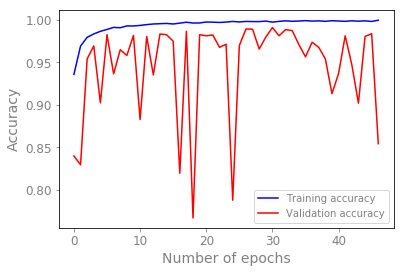

In [19]:
train_acc = history.history['acc']  # Accuracy of each epoch    
val_acc = history.history['val_acc']  # Validation accuracy of each epoch

plt.plot(train_acc, label = 'Training accuracy', color = 'b')
plt.plot(val_acc, label = "Validation accuracy", color = 'r')

plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend()

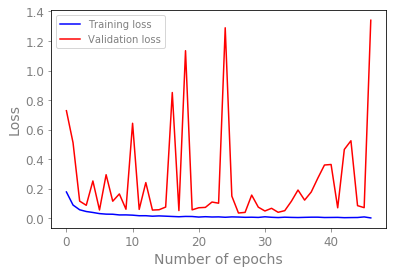

In [20]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(train_loss, label = 'Training loss', color = 'b')
plt.plot(val_loss, label = 'Validation loss', color = 'r')

plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend()

# Making predictions

In [0]:
model.load_weights("best_model.h5")

In [22]:
# Counts number of files in test set in 'unknown/test/'
list = os.listdir(test_dir) 
pred_steps = len(list)

print(pred_steps)

4000


In [23]:
test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_directory(directory = 'unknown/',
                                             batch_size = 1, 
                                             target_size = (32, 32),
                                             class_mode = None, 
                                             shuffle = False)

Found 4000 images belonging to 1 classes.


flow_from_directory checks ```directory``` for any subfolders containing test images. ```directory``` requires a subfolder containing test files, but the argument takes the parent folder (containing the subfolder) only.

Test files in ```'unknown/test'``` but ```directory = 'unknown/'```.

In [0]:
test_pred = model.predict_generator(test_generator, 
                                    steps = pred_steps)

In [25]:
test_pred

array([[1.000000e+00],
       [1.000000e+00],
       [3.376091e-04],
       ...,
       [1.000000e+00],
       [1.000000e+00],
       [9.999999e-01]], dtype=float32)

In [0]:
# Converting to binary
results = (test_pred >= 0.5).astype(int)

In [0]:
results = np.concatenate(results, axis = None)

In [28]:
results

array([1, 1, 0, ..., 1, 1, 1])

In [29]:
# Filenames of test images in unknown/test
test_id = os.listdir(test_dir)
sorted_test_id = sorted(test_id)

len(sorted_test_id)

4000

In [0]:
submission = pd.DataFrame({'id': sorted_test_id, 'has_cactus': results})

In [31]:
submission.iloc[: 5]

,id,has_cactus
0,000940378805c44108d287872b2f04ce.jpg,1
1,0017242f54ececa4512b4d7937d1e21e.jpg,1
2,001ee6d8564003107853118ab87df407.jpg,0
3,002e175c3c1e060769475f52182583d0.jpg,0
4,0036e44a7e8f7218e9bc7bf8137e4943.jpg,1


In [0]:
submission.to_csv('aerial-cactus.csv', index = False)
# files.download('aerial-cactus.csv')

### References

1. [Getting started with CNN and VGG16](https://www.kaggle.com/shahules/getting-started-with-cnn-and-vgg16)
2. [Simple CNN using Keras](https://www.kaggle.com/frlemarchand/simple-cnn-using-keras)